# Patterns in Kickstarter records

### _Lukas Vlcek_

Kickstarter records contain more than 200,000 projects, with information about their ultimate success or failure, type of the proposed work, country of origin, or amounts of money asked and pledged by funders.

Potential proposers, as well as funders, need to consider whether their investment of time and money will ultimately pay off. It is possible that the historical records contain information that will allow them to make more informed decisions about the probability of successful funding and weigh those agains their costs.

For instance, the proposers may be able to optimize the amounts asked, or, if they have multiple ideas, choose a category with the highest likelihood of funding. It may be also worthwile to consider their country of origin as the funders may be home-biased.

Funders may take guidance from the 'staff picks', which can be considered the endorsements of the Kickstarter staff. However, we may ask how predictive these picks are, or whether we can improve their predictive value by creating models based on the data.

## 1. Setup

**Notebook configuration**

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

**Create a dataframe from a pre-processed CSV file, and list its basic parameters **

In [31]:
target_path = '../data/processed'
filename = 'kick_id.csv'
datecols = ['created_at', 'deadline', 'state_changed_at', 'launched_at']
fdatpars = lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
df = pd.read_csv(os.path.join(target_path, filename), index_col='id', parse_dates=datecols, date_parser=fdatpars)
df = df.drop(['disable_communication'], axis='columns')

** Filter out ongoing (live) and suspended projects. The live projects can be used to test predictions as the funding period concludes **

In [36]:
df = df.loc[(df['state'] != 'live') & (df['state'] != 'suspended')]

** Merge 162 categories to 15 more general category types for easier analysis and better statistics **

In [37]:
cat_type = [x.split('/')[0] for x in df['category'].values]
df['cat_type'] = np.array(cat_type)

## 2. Basic statistics for different features

### 2.1 The first look at the overall success/failure rates

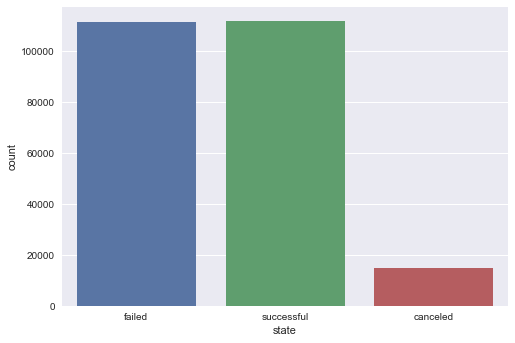

In [38]:
sns.countplot(x='state', data=df)

### Observation
* About half the projects were successfully funded

### 2.2 Overall funding goals vs. pledges

In [6]:
df[['goal', 'usd_pledged']].describe()

,goal,usd_pledged
count,2.384560e+05,2.384560e+05
mean,4.520084e+04,1.122812e+04
std,1.114512e+06,1.067187e+05
min,1.000000e-02,0.000000e+00
25%,2.000000e+03,5.000000e+01
50%,5.000000e+03,1.020160e+03
75%,1.500000e+04,5.325000e+03
max,1.000000e+08,2.033899e+07


** Look at the extreme goals **

** Q: Are the maximum goals legitimate? **

In [7]:
df_max = df.loc[df['goal'] == 1e8][['name','category','usd_pledged','backers_count','country','blurb']].sort_values(by='category').reset_index()
df_max.tail()

,id,name,category,usd_pledged,backers_count,country,blurb
14,1119122774,"Help me start a fair media company, Trump Media",journalism/video,1.000000,1,US,"You might be asking why I decided to call it ""..."
15,487345242,Billionaire Boy Blog (Canceled),publishing/young adult,0.000000,0,DK,An exclusive blog about a 18 year old milliona...
16,953415668,Currency Free System,technology/software,0.502121,1,MX,CF is an independent currency system and a tra...
17,1601563193,Our future,technology/space exploration,0.928942,1,AU,The new century has begun may our life's get e...
18,2083255961,A Billion Pixels...,technology/web,56.000000,6,US,"A billion pixel website, a billion pixel displ..."


In [8]:
# Trump media company
print(df_max.loc[14][6])

You might be asking why I decided to call it "Trump Media," well its simple. Our media will "trump" the lame stream media


In [9]:
# Billionaire boy
print(df_max.loc[15][6])

An exclusive blog about a 18 year old millionaire.
The blod will consist of fashion, cars, sport, travelling and much more.


In [10]:
# New currency
print(df_max.loc[16][6])

CF is an independent currency system and a trading tool that runs parallel to all existing currency systems.


** A: The extreme goals seem suspicious and seem to discourage funding (minimum pledged amounts)**

** Possible advice: Filter these out.**

### 2.3 Closer look at the category property

** Questions **

1. Are the success rates and funding strongly dependent on the category?
2. What are the most promising categories in terms of likelihood of funding and the overal amounts obtained?

In [11]:
# number of different categories
print("Number of categories:", df['category'].value_counts().shape[0])
print("Most frequent category:", df['category'].value_counts().head(1))
print("Least frequent category:", df['category'].value_counts().tail(1))
#df['category'].value_counts()

Number of categories: 169
Most frequent category: games/video games    7340
Name: category, dtype: int64
Least frequent category: crafts/taxidermy    11
Name: category, dtype: int64


** Observation **
* There are too many (169) categories for easy evaluation, going from the most frequent 'games/video games' (7340) to the least frequent 'crafts/taxidermy' (11)
* It is easier to analyze the trends in terms for general category types, that can be extracted from the category names.
* This coarse-graining will also improve the statistics for model development.

** Category types statistics **

Number of category types: 15
film & video    36225
music           34954
publishing      29462
technology      24341
games           20360
art             20214
food            15059
fashion         14150
design          10277
comics           7745
photography      6717
theater          6190
crafts           5495
journalism       4225
dance            3042
Name: cat_type, dtype: int64


The most frequent category type is 'film & video', while the least frequent is 'dance'.

** Q: What are the success rates for different categories? **

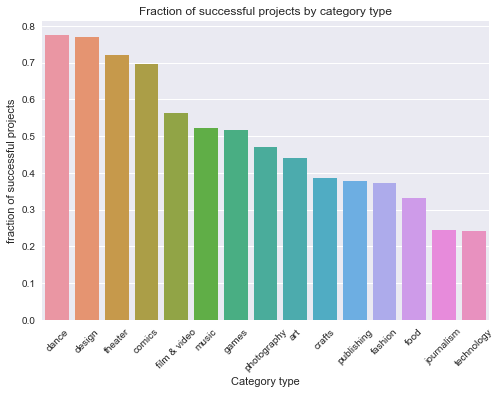

In [13]:
pt = df.pivot_table(index='cat_type', columns='state', values='country', aggfunc='count')
#pt
x = (pt['successful']/(pt.sum(axis='columns'))).to_frame(name='ratio').sort_values(by='ratio', ascending=False)
sns.barplot(x=x.index, y='ratio', data=x)
plt.xticks(rotation=45)
plt.xlabel('Category type')
plt.ylabel('fraction of successful projects')
plt.title('Fraction of successful projects by category type')

** A: Dance and design have the highest success rate, while technology and journalism the least **

** Q: What are the median amounts targeted and pledged? **

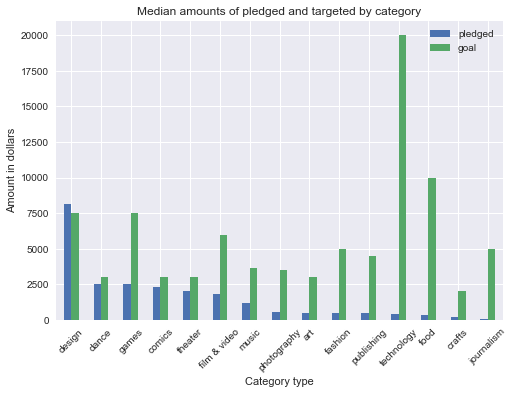

In [14]:
gp = df.groupby('cat_type').median()[['goal','pledged']].sort_values(by='pledged', ascending=False)
gp.plot(y=['pledged','goal'], kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Category type')
plt.ylabel('Amount in dollars')
plt.title('Median amounts of pledged and targeted by category')

** Q: What are the total amounts invested in different categories? **

              pledged
cat_type             
dance     13112260.43


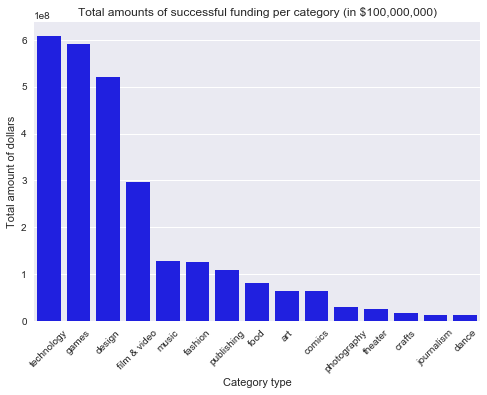

In [30]:
pl = df.loc[df.state == 'successful'].groupby('cat_type').sum()[['pledged']].sort_values(by='pledged', ascending=False)
sns.barplot(x=pl.index, y='pledged', data=pl, color='blue')
plt.xlabel('Category type')
plt.ylabel('Total amount of dollars')
plt.title("Total amounts of successful funding per category (in $100,000,000)")
plt.xticks(rotation=45)
print(pl.tail(1))

** A: While the investments into technolgy were ~ \$600M, even the smallest dance category attracted \$13M. **

Given the low median for technology, the successful technology projects attract large amounts

** A: Most of the \$100M goals look suspicious **

** Q: Is there any correlation between goals and pledged amount? **

(0, 21000000.0)

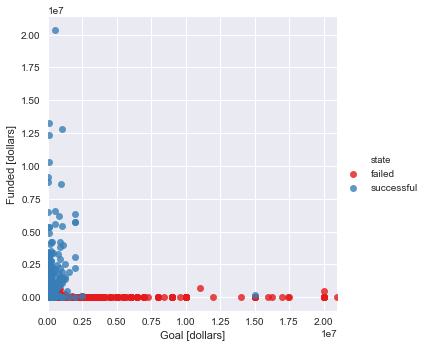

In [16]:
sns.lmplot(x='goal', y='usd_pledged', hue='state', data=df.loc[df.state != 'canceled'], fit_reg=False, palette='Set1')
plt.xlabel('Goal [dollars]')
plt.ylabel('Funded [dollars]')
plt.xlim(0,2.1e7)

* Note that the extreme goals were left out to preserve the same scale on the axes.

** A: The relation between goals and money actually obtained seems inverse -> To get funding don't ask too much **

* Successful funding campain should be easier with lower target, but asking less also helps to get more money
* Lowballing a good strategy?
    * May get staff endorsment
    * Better perception of achievability
    * Large funding goals scare people away
    * Large funding goals may be correlate with poor planning or crackpot ideas?

## Are staff picks predictive?

* The Kicksarter staff can review a project and judge its merits based on its content.
* How good are these recomendations as a predictor of the actual success?

In [18]:
pt = df.pivot_table(index='staff_pick', columns='state', values='country', aggfunc='count')
print("Fraction of staff-picked projects:", df['staff_pick'].sum()/len(df))
print("Success rate of a random project:      ", pt.loc[:, 'successful'].sum()/(pt.loc[True,:].sum()+pt.loc[False,:].sum()))
print("Success rate of a staff-picked project:",pt.loc[True, 'successful']/pt.loc[True,:].sum())
print("Success rate of a non-picked project:  ",pt.loc[False, 'successful']/pt.loc[False,:].sum())

Fraction of staff-picked projects: 0.11634850874
Success rate of a random project:       0.4689083101284933
Success rate of a staff-picked project: 0.8473183391
Success rate of a non-picked project:   0.419083868028


** A: Staff pick almost doubles the chances of a project being succesful. **

** Q: Can a model based on the statistical data beat the staff pick as a predictor? **

** Q: Can a combination of the data with the staff pick improve the predictions? **

** Q: What kind of information can be used for predictions? Category? Goal amount? Country? **


** We have seen that Dance and Design categories have success rates aroud 75% **
** Q: Can a combination of the category and staff pick improve the results? (If simply successful funding is the measure)**

In [19]:
success = df.loc[(df.staff_pick == True) & (df.cat_type == 'dance') & (df.state == 'successful')]['goal'].count()/df.loc[(df.staff_pick == True) & (df.cat_type == 'dance')]['goal'].count()
print('Success rate for staff-picked dance projects:', success)

Success rate for staff-picked dance projects: 0.914691943128


In [20]:
success = df.loc[(df.staff_pick == True) & (df.cat_type == 'design') & (df.state == 'successful')]['goal'].count()/df.loc[(df.staff_pick == True) & (df.cat_type == 'design')]['goal'].count()
print('Success rate for staff-picked dance projects:', success)

Success rate for staff-picked dance projects: 0.952941176471


** Simply combining the staff pick with the design category brings the success rate to 95% **

In [21]:
df.loc[(df.country == 'MX') & (df.cat_type == 'dance')]['goal'].count()/df.loc[(df.cat_type == 'dance')]['goal'].count()

0.0069033530571992107

### Country of origin statistics

** Q: Are there any 'cultural' trends that affect the funding goals and choice of categories? **

Number of countries: 22


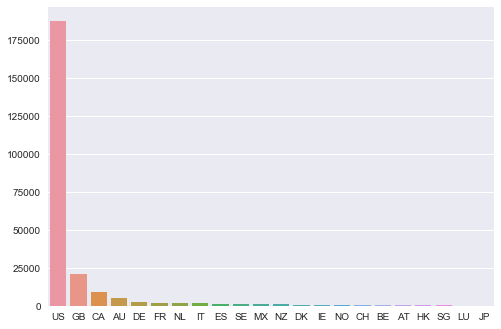

In [22]:
# Number of projects from different countries
print('Number of countries:', df['country'].value_counts().shape[0])
a = df['country'].value_counts()
sns.barplot(a.index, a.values)

** Majority of projects come from US, GB, CA **

(0, 1000000.0)

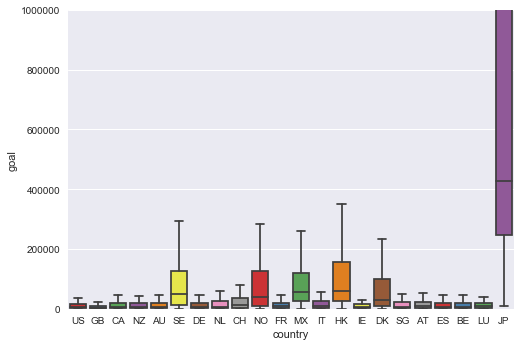

In [23]:
sns.boxplot(x='country', y='goal', data=df, palette='Set1', fliersize=0)
plt.ylim(0,1e6)

(0, 20000.0)

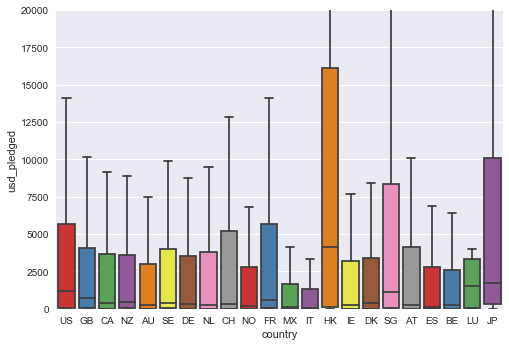

In [24]:
sns.boxplot(x='country', y='usd_pledged', data=df, palette='Set1', fliersize=0)
plt.ylim(0,2e4)

* 22 countries 
* Asian countries (HK, SG, JP) get a lot, no matter how much they ask
* Hong Kong asks a lot and gets a lot
* Japanese ask the most, get good funding (could there be some currency mess-up with Japanese Yen?)
* Singapore (SG) and Swiss (CH) don't ask much, but get a lot 
* Scandinavian countries ask a lot - get same as other Europeans
* Mexicans ask a lot, get the least
* Americans don't ask much, but still are funded well

Can unsupervised methods group countries by their geography?
* What decides? - culture, GDP, types of popular projects

In [25]:
ct_jp = df.loc[(df['country'] == 'JP')].fillna(0)['cat_type'].value_counts()
ct_hk = df.loc[(df['country'] == 'HK')].fillna(0)['cat_type'].value_counts()
ct_sg = df.loc[(df['country'] == 'SG')].fillna(0)['cat_type'].value_counts()
ct_mx = df.loc[(df['country'] == 'MX')].fillna(0)['cat_type'].value_counts()
ct_dk = df.loc[(df['country'] == 'DK')].fillna(0)['cat_type'].value_counts()
ct_se = df.loc[(df['country'] == 'SE')].fillna(0)['cat_type'].value_counts()
ct_no = df.loc[(df['country'] == 'NO')].fillna(0)['cat_type'].value_counts()
df_ct = pd.DataFrame()
df_ct['jp'] = ct_jp
df_ct['hk'] = ct_hk
df_ct['sg'] = ct_sg
df_ct['mx'] = ct_mx
df_ct['dk'] = ct_dk
df_ct['se'] = ct_se
df_ct['no'] = ct_no
df_ct = df_ct[['jp','hk','sg','dk','se','no','mx']].transform(lambda x: x / x.sum())

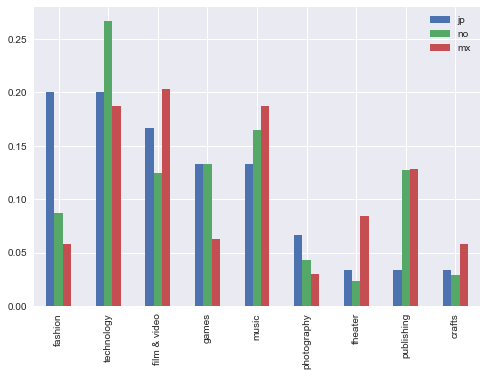

In [26]:
df_ct.plot(y=['jp','no','mx'], kind='bar')

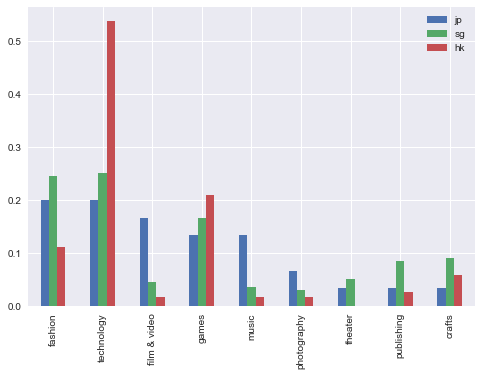

In [27]:
df_ct.plot(y=['jp','sg','hk'], kind='bar')

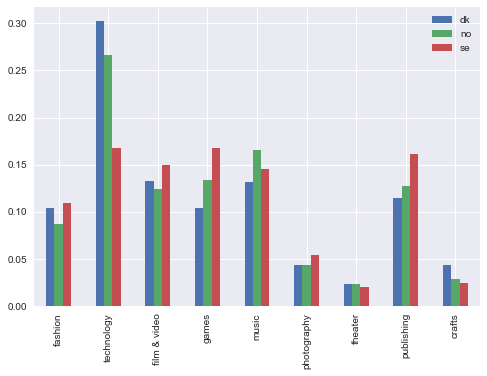

In [28]:
df_ct.plot(y=['dk','no','se'], kind='bar')

** A: There are visible 'cultural' trends seen in the categories.**

* Scandinavian countries: Denmark, Sweden, Norway - almost same
* Asian countries are more diverse: Japan and Singapore similar, Hong-kong differs
* Hong-kong - most technology and games focused
* Mexico - the least technology

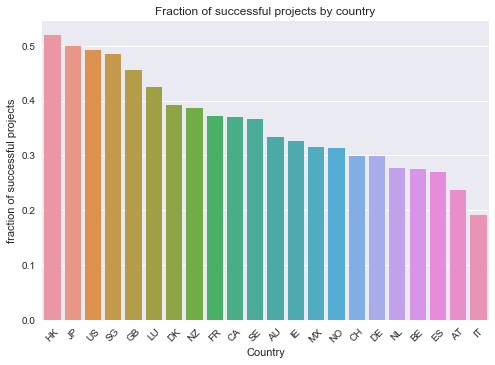

In [29]:
pt = df.pivot_table(index='country', columns='state', values='goal', aggfunc='count')
#print(pt)
x = (pt['successful']/(pt.sum(axis='columns'))).to_frame(name='ratio').sort_values(by='ratio', ascending=False)
sns.barplot(x=x.index, y='ratio', data=x)
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('fraction of successful projects')
plt.title('Fraction of successful projects by country')

1. ** The three asian countries occupy 1st, 2nd, and 4th highest success rates. **

2. ** Projects from Europe have average or poor success rate **

What is the best strategy if you have a particular project in mind?